In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Lambda
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import holidays
import matplotlib.pyplot as plt

df = pd.read_csv('filtered_reservation_failed_rev2.csv')
print("원본 df shape:", df.shape)
print(df.head(), "\n")

# 출발일자(YYYYMMDD) → datetime
df['depart_date'] = pd.to_datetime(df['출발일자'], format='%Y%m%d')

# 출발시각(HHMMSS) 문자열(6자리)로
df['time_str'] = df['출발시각'].astype(str).str.zfill(6)

# 문자열에서 시,분,초 분리
df['hour']   = df['time_str'].str[0:2].astype(int)
df['minute'] = df['time_str'].str[2:4].astype(int)
df['second'] = df['time_str'].str[4:6].astype(int)

# 최종 depart_dt 생성
df['depart_dt'] = (
    df['depart_date']
    + pd.to_timedelta(df['hour'],   unit='h')
    + pd.to_timedelta(df['minute'], unit='m')
    + pd.to_timedelta(df['second'], unit='s')
)

print("depart_dt:")
print(df[['출발시각','time_str','hour','minute','second','depart_dt']].head(), "\n")


원본 df shape: (4162560, 5)
  출발역 도착역      출발일자  출발시각  예약실패건수
0  경산  광명  20241021     0       0
1  경산  광명  20241021  1000       0
2  경산  광명  20241021  2000       0
3  경산  광명  20241021  3000       0
4  경산  광명  20241021  4000       0 

time_str sample / parsed depart_dt:
   출발시각 time_str  hour  minute  second           depart_dt
0     0   000000     0       0       0 2024-10-21 00:00:00
1  1000   001000     0      10       0 2024-10-21 00:10:00
2  2000   002000     0      20       0 2024-10-21 00:20:00
3  3000   003000     0      30       0 2024-10-21 00:30:00
4  4000   004000     0      40       0 2024-10-21 00:40:00 



In [ ]:
df['dow']        = df['depart_dt'].dt.weekday
df['is_weekend'] = df['dow'].isin([5,6]).astype(int)
kr_holidays      = holidays.KR()
df['is_holiday'] = df['depart_dt'].dt.date.map(lambda d: int(d in kr_holidays))

print("요일, 주말, 공휴일:")
print(df[['depart_dt','dow','is_weekend','is_holiday']].drop_duplicates().head(), "\n")


달력 피처 sample:
            depart_dt  dow  is_weekend  is_holiday
0 2024-10-21 00:00:00    0           0           0
1 2024-10-21 00:10:00    0           0           0
2 2024-10-21 00:20:00    0           0           0
3 2024-10-21 00:30:00    0           0           0
4 2024-10-21 00:40:00    0           0           0 



In [ ]:
weather = pd.read_csv(
    'OBS_ASOS_TIM_20250507162026.csv',
    parse_dates=['일시'],
    encoding='euc_kr'
).rename(columns={
    '지점명':      'station',
    '일시':        'depart_dt',
    '기온(°C)':   'temp',
    '강수량(mm)': 'precip',
    '적설(cm)':   'snow'
})

# station+depart_dt 기상정보
weather_agg = (
    weather
    .groupby(['station','depart_dt'])[['temp','precip','snow']]
    .mean()
    .reset_index()
)

# 역명 → 기상지점 매핑 테이블
station_to_weather = {
    '행신':'서울', '영등포':'서울', 
    '서울':'서울', '광명':'서울',
    '용산':'서울', '천안아산':'천안',
    '오송':'청주', '대전':'대전',
    '김천구미':'구미', '공주':'대전',
    '동대구':'대구', '익산':'전주',
    '정읍':'정읍', '전주':'전주',
    '경산':'대구', '경주':'경주',
    '광주송정':'광주', '남원':'남원',
    '밀양':'밀양', '포항':'포항',
    '나주':'광주', '곡성':'광주',
    '울산':'울산', '창원중앙':'창원',
    '창원':'창원', '부산':'부산',   
    '마산':'창원', '진주':'진주',
    '목포':'목포',  '구례구':'순천',
    '순천':'순천', '여천':'여수',
    '여수엑스포':'여수'  
}

print("weather_agg:", weather_agg.shape)
print(weather_agg.head(), "\n")

weather_agg: (158117, 5)
  station           depart_dt  temp  precip  snow
0      강릉 2024-10-21 00:00:00  11.7     NaN   NaN
1      강릉 2024-10-21 01:00:00  11.8     NaN   NaN
2      강릉 2024-10-21 02:00:00  11.9     NaN   NaN
3      강릉 2024-10-21 03:00:00  11.9     NaN   NaN
4      강릉 2024-10-21 04:00:00  12.4     NaN   NaN 

station_to_weather 예시: [('행신', '서울'), ('영등포', '서울'), ('서울', '서울'), ('광명', '서울'), ('용산', '서울')]


In [ ]:
# OD별 집계
df['OD'] = df['출발역'].astype(str) + '_' + df['도착역'].astype(str)
df2 = (
    df
    .groupby(['depart_dt','OD'], as_index=False)
    .agg({
        '예약실패건수':'sum',
        'dow':'first',
        'is_weekend':'first',
        'is_holiday':'first'
    })
)

# OD 분리
df2[['orig','dest']] = df2['OD'].str.split('_', expand=True)

# 출발, 도착역 → station 매핑
df2['weather_dep'] = df2['orig'].map(station_to_weather)
df2['weather_arr'] = df2['dest'].map(station_to_weather)

# depart_dt+weather_dep(출발역 날씨) 기준으로 merge
df2 = df2.merge(
    weather_agg,
    left_on=['weather_dep','depart_dt'],
    right_on=['station','depart_dt'],
    how='left'
).rename(columns={
    'temp':   'temp_dep',
    'precip': 'precip_dep',
    'snow':   'snow_dep'
}).drop(columns=['station'])

# depart_dt+weather_arr(도착역 날씨) 기준으로 merge
df2 = df2.merge(
    weather_agg,
    left_on=['weather_arr','depart_dt'],
    right_on=['station','depart_dt'],
    how='left'
).rename(columns={
    'temp':   'temp_arr',
    'precip': 'precip_arr',
    'snow':   'snow_arr'
}).drop(columns=['station'])

# 결측치 채우기
for c in [
    'temp_dep','precip_dep','snow_dep',
    'temp_arr','precip_arr','snow_arr'
]:
    df2[c] = df2[c].ffill().fillna(0)

print("최종 df2 shape:", df2.shape)
print(df2[['OD','weather_dep','weather_arr','temp_dep','temp_arr']].head())


최종 df2 shape: (4162560, 16)
        OD weather_dep weather_arr  temp_dep  temp_arr
0    경산_광명          대구          서울      15.2      10.8
1  경산_김천구미          대구          구미      15.2      12.3
2    경산_대전          대구          대전      15.2      10.2
3   경산_동대구          대구          대구      15.2      15.2
4    경산_마산          대구          창원      15.2      15.6


In [ ]:
# 노선별 역 리스트 정의
lines = {
    '경부': ['행신','서울','영등포','광명','천안아산','오송','대전','김천구미','동대구','경주','울산','부산'],
    '경전': ['행신','서울','광명','천안아산','오송','대전','김천구미','동대구','경산','밀양','창원중앙','창원','마산','진주'],
    '동해': ['행신','서울','광명','천안아산','오송','대전','김천구미','동대구','경주','포항'],
    '호남': ['행신','서울','용산','광명','천안아산','오송','공주','익산','정읍','광주송정','나주','목포'],
    '전라': ['행신','서울','용산','광명','천안아산','오송','공주','익산','전주','남원','곡성','구례구','순천','여천','여수엑스포']
}

# OD의 출발역/도착역 라인 할당
def map_line(od):
    orig, dest = od.split('_')
    for line, stations in lines.items():
        if orig in stations and dest in stations:
            return line
    return '기타'

df2['line'] = df2['OD'].map(map_line)

print("라인 할당:")
print(df2[['OD','line']].drop_duplicates().head(10))


라인 할당 예시:
        OD line
0    경산_광명   경전
1  경산_김천구미   경전
2    경산_대전   경전
3   경산_동대구   경전
4    경산_마산   경전
5    경산_밀양   경전
6    경산_서울   경전
7    경산_오송   경전
8    경산_진주   경전
9    경산_창원   경전


In [ ]:
# pivot → ts_fail
ts_fail = (
    df2
    .pivot(index='depart_dt', columns='OD', values='예약실패건수')
    .fillna(0)
    .sort_index()
)

# depart_dt별 달력,양쪽 날씨만 추출
cal_weather = (
    df2[[
        'depart_dt',
        'dow','is_weekend','is_holiday',
        'temp_dep','precip_dep','snow_dep',
        'temp_arr','precip_arr','snow_arr'
    ]]
    .drop_duplicates(subset='depart_dt')
    .set_index('depart_dt')
    .loc[ts_fail.index]     
    .astype('float32')
)

feat_ts = cal_weather

print("ts_fail shape:", ts_fail.shape)    # (7680, 542)
print("feat_ts shape:", feat_ts.shape)    # (7680, 9)
print("feat_ts head:\n", feat_ts.head(), "\n")


ts_fail shape: (7680, 542)
feat_ts shape: (7680, 9)
ts_fail columns sample: Index(['경산_광명', '경산_김천구미', '경산_대전', '경산_동대구', '경산_마산', '경산_밀양', '경산_서울',
       '경산_오송', '경산_진주', '경산_창원', '경산_창원중앙', '경산_천안아산', '경산_행신', '경주_광명',
       '경주_김천구미', '경주_대전', '경주_동대구', '경주_부산', '경주_서울', '경주_영등포'],
      dtype='object', name='OD') 

feat_ts head:
                      dow  is_weekend  is_holiday  temp_dep  precip_dep  \
depart_dt                                                                
2024-10-21 00:00:00  0.0         0.0         0.0      15.2         0.0   
2024-10-21 00:10:00  0.0         0.0         0.0      10.8         0.0   
2024-10-21 00:20:00  0.0         0.0         0.0      10.8         0.0   
2024-10-21 00:30:00  0.0         0.0         0.0      10.8         0.0   
2024-10-21 00:40:00  0.0         0.0         0.0      10.8         0.0   

                     snow_dep  temp_arr  precip_arr  snow_arr  
depart_dt                                                      
2024-10-21 00:

In [ ]:
idx = ts_fail.index
mask = (idx.hour >= 5) | (idx.hour <= 1)

ts_fail = ts_fail.loc[mask]
feat_ts  = feat_ts.loc[mask]

print("05~01시 필터 shapes:")
print(" ts_fail:", ts_fail.shape)
print(" feat_ts:", feat_ts.shape)


서비스 시간대(05~01시) 필터 후 shapes:
 ts_fail: (7680, 542)
 feat_ts: (7680, 9)


In [ ]:
scaler_fail = MinMaxScaler()
scaler_feat = MinMaxScaler()
ts_fail_scaled = pd.DataFrame(
    scaler_fail.fit_transform(ts_fail),
    index=ts_fail.index, columns=ts_fail.columns
)
feat_scaled = pd.DataFrame(
    scaler_feat.fit_transform(feat_ts),
    index=feat_ts.index, columns=feat_ts.columns
)

print("정규화 후 ts_fail_scaled head:")
print(ts_fail_scaled.iloc[:5, :3], "\n")
print("정규화 후 feat_scaled head:")
print(feat_scaled.head(), "\n")


정규화 후 예시 ts_fail_scaled head:
OD                   경산_광명  경산_김천구미  경산_대전
depart_dt                                 
2024-10-21 00:00:00    0.0      0.0    0.0
2024-10-21 00:10:00    0.0      0.0    0.0
2024-10-21 00:20:00    0.0      0.0    0.0
2024-10-21 00:30:00    0.0      0.0    0.0
2024-10-21 00:40:00    0.0      0.0    0.0 

정규화 후 feat_scaled head:
                     dow  is_weekend  is_holiday  temp_dep  precip_dep  \
depart_dt                                                                
2024-10-21 00:00:00  0.0         0.0         0.0  0.695238         0.0   
2024-10-21 00:10:00  0.0         0.0         0.0  0.555556         0.0   
2024-10-21 00:20:00  0.0         0.0         0.0  0.555556         0.0   
2024-10-21 00:30:00  0.0         0.0         0.0  0.555556         0.0   
2024-10-21 00:40:00  0.0         0.0         0.0  0.555556         0.0   

                     snow_dep  temp_arr  precip_arr  snow_arr  
depart_dt                                                   

In [ ]:
SEQ_LEN = 6
def make_sequences(series, feats):
    X, y = [], []
    for i in range(len(series) - SEQ_LEN):
        seq_fail = series[i:i+SEQ_LEN].reshape(-1,1)
        seq_feat = feats.iloc[i:i+SEQ_LEN].values
        X.append(np.hstack([seq_fail, seq_feat]))
        y.append(series[i+SEQ_LEN])
    return np.array(X), np.array(y)

# 테스트 OD
sample_od = ts_fail_scaled.columns[0]
Xs, ys = make_sequences(ts_fail_scaled[sample_od].values, feat_scaled)
print(f"{sample_od} 시퀀스 X shape:", Xs.shape, "y shape:", ys.shape, "\n")


경산_광명 시퀀스 X shape: (7674, 6, 10) y shape: (7674,) 



In [ ]:
results = {}
for od in ts_fail_scaled.columns:
    series = ts_fail_scaled[od].values
    X, y   = make_sequences(series, feat_scaled)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    
    X_train, X_test = X_train.astype('float32'), X_test.astype('float32')
    y_train, y_test = y_train.astype('float32'), y_test.astype('float32')

    inp = Input(shape=(SEQ_LEN, X.shape[-1]))
    lstm_out, st_h, _ = LSTM(32, return_sequences=True, return_state=True)(inp)
    q = Lambda(lambda x: tf.expand_dims(x,1))(st_h)
    attn = Attention()([q, lstm_out])
    attn = Lambda(lambda x: tf.squeeze(x,1))(attn)
    out  = Dense(1)(attn)

    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=0)

    _, mae = model.evaluate(X_test, y_test, verbose=0)
    results[od] = mae

print("학습 완료, OD 개수:", len(results), "\n")


학습·평가 완료, OD 개수: 542 



평균 MAE: 0.00987218591454181

Worst 5 OD:
            OD       MAE
81      광명_전주  0.026083
541     행신_포항  0.023964
171   대전_창원중앙  0.023958
338     오송_마산  0.023207
480  천안아산_동대구  0.022974

Best 5 OD:
            OD       MAE
285   순천_천안아산  0.001305
352     오송_진주  0.001572
160   대전_김천구미  0.001878
33      곡성_오송  0.001884
190  동대구_천안아산  0.002018 



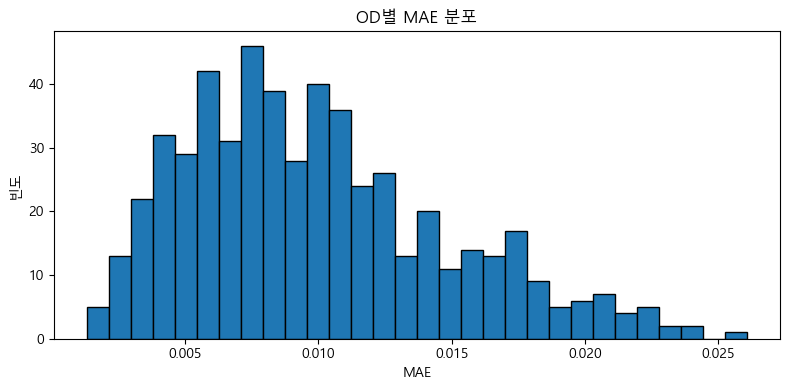

In [ ]:
mae_df = pd.Series(results, name='MAE').reset_index()
mae_df.columns = ['OD','MAE']

print("평균 MAE:", mae_df['MAE'].mean())
print("\nWorst 5 OD:\n", mae_df.nlargest(5,'MAE'))
print("\nBest 5 OD:\n", mae_df.nsmallest(5,'MAE'), "\n")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8,4))
plt.hist(mae_df['MAE'], bins=30, edgecolor='k')
plt.title('OD별 MAE 분포')
plt.xlabel('MAE')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()